### test implementing basic EMF iterations

TODO:  check second iteration--why is it 'off' -- why don't h values change ?

- work through by hand...maybe print out  
- because we are sampling ?  

implement:  get free energy, entropy, and energy distributions

test on mnist:  can we measure entropy, energy, weights


In [1]:
import numpy as np
import h5py

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  

/Users/charlesmartin14/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from sklearn.utils.fixes import expit    
from sklearn.utils.extmath import safe_sparse_dot
from sklearn import linear_model, datasets, metrics, preprocessing 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
def sig_means(x, b, W):
    a = safe_sparse_dot(x, W.T) + b
    return expit(a, out=a)

### use julia data set

I don't know how to reproduce their normalization yet

In [4]:
hf =  h5py.File('mnist.h5','r')
print('List of arrays in this file: \n', hf.keys())
X = np.array(hf.get('HDF5.name___X'))
Y = np.array(hf.get('HDF5.name___y'))
print X.shape, Y.shape
hf.close()
print "norm of X ",np.linalg.norm(X,ord=2)

('List of arrays in this file: \n', [u'HDF5.name___X', u'HDF5.name___y'])
(60000, 784) (60000,)
norm of X  2117.63422548


### plot the new mnist data

In [5]:
def show(image):
    """
    Render a given numpy.uint8 array of pixel data.
    Reshape array, and rotate for display
    """
    square_image = np.rot90(np.reshape(image, [28,28]))
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(square_image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.show()


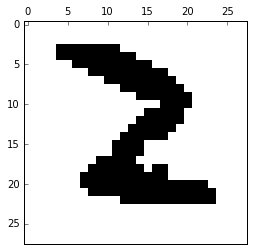

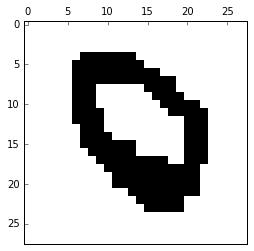

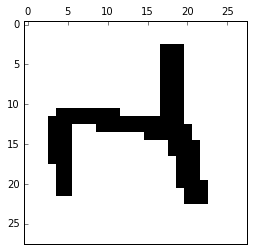

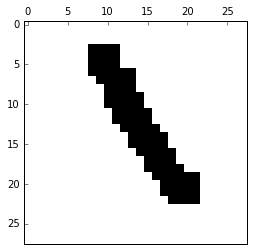

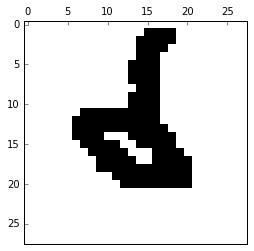

In [6]:
for i in range(5):
    show(X[i,:])

Notice that the images are binary now, not greyscale

### Implement RBM and Test

Eventually need to convert to sklearn code

Using as much as existing RBM code as I can now

In [7]:
from sklearn.externals.six.moves import xrange
from sklearn.utils import check_array
from sklearn.utils import check_random_state
from sklearn.utils import gen_even_slices
from sklearn.utils import issparse
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.extmath import log_logistic
from sklearn.utils.fixes import expit             # logistic function
from sklearn.utils.validation import check_is_fitted

In [8]:
def init_v_bias(X):
    # If the user specifies the training dataset, it can be useful to                                                                                   
    # initialize the visibile biases according to the empirical expected                                                                                
    # feature values of the training data.                                                                                                              
    #                                                                                                                                                   
    # TODO: Generalize this biasing. Currently, the biasing is only written for                                                                         
    #       the case of binary RBMs.
    eps = 1e-8

    probVis = np.mean(X,axis=0)             # Mean across  samples 
    print np.linalg.norm(X[0,:], ord=2)
    print "mean X",np.linalg.norm(probVis, ord=2)

    probVis[probVis < eps] = eps            # Some regularization (avoid Inf/NaN)  
    print "norm probVis",np.linalg.norm(probVis, ord=2)

    #probVis[probVis < (1.0-eps)] = (1.0-eps)   
    v_bias = np.log(probVis / (1.0-probVis)) # Biasing as the log-proportion  
    return v_bias

In [9]:
class EMF_RBM():
    def __init__(self, n_components=256, learning_rate=0.005, batch_size=100, sigma=0.001, neq_steps = 3,
                 n_iter=20, verbose=0, random_state=None, momentum = 0.5, decay = 0.01, weight_decay='L1'):
        self.n_components = n_components
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_iter = n_iter
        self.verbose = verbose
        
        self.momentum = momentum
        self.decay = decay
        self.weight_decay = weight_decay
            
        self.sigma = sigma
        self.neq_steps = neq_steps
        
        # self.random_state_ = random_state
        # always start with new random state
        self.rng = check_random_state(random_state)
        
        # initialize arrays to 0
        self.W = np.asarray(
            self.rng.normal(
                0,
                sigma,
                (self.n_components, X.shape[1])
            ),
            order='fortran')
        
        self.dW_prev = np.zeros_like(self.W)
        self.W2 = self.W*self.W


        self.h_bias = np.zeros(self.n_components, )
        #self.v_bias = np.zeros(X.shape[1], )
        self.h_samples_ = np.zeros((self.batch_size, self.n_components))
        
        # learning rate / mini_batch
        self.lr = 0.0
        
        print "W emf_init norm ", np.linalg.norm(self.W, ord=2)

        # init vbias
        print X[0:50000,:].shape
        self.v_bias = init_v_bias(X[0:50000,:])
        print "v bias emf_init shape ",self.v_bias.shape

        print "v bias emf_init norm ", np.linalg.norm(self.v_bias, ord=2)
        print "h bias emf_init norm ", np.linalg.norm(self.h_bias, ord=2)



In [10]:
rbm = EMF_RBM(momentum=0.5, decay=0.01, learning_rate=0.005, n_iter=20, sigma=1e-20)

W emf_init norm  4.41857505506e-19
(50000, 784)
12.8840987267
mean X 8.43148429713
norm probVis 8.43148429713
v bias emf_init shape  (784,)
v bias emf_init norm  195.129720728
h bias emf_init norm  0.0


In [11]:
def sample_layer(rbm, layer):
    return (rbm.rng.random_sample(size=l.shape) < layer)  

In [12]:
def _sample_hiddens(rbm, v):
    return sample_layer(rbm, _mean_hiddens(rbm, v))

In [97]:
def _mean_hiddens(rbm, v):
    p = safe_sparse_dot(v, rbm.W.T) + rbm.h_bias
    print "mean hiddens W: ",np.linalg.norm(rbm.W.T, ord=2)," v: ",np.linalg.norm(v, ord=2)," h: ",np.linalg.norm(rbm.h_bias, ord=2),  " p: ",   np.linalg.norm(p, ord=2)
    return expit(p, out=p)

In [98]:
def _mean_visibles(rbm, h):
    p = np.dot(h, rbm.W) + rbm.v_bias
    return expit(p, out=p)

In [99]:
def _sample_visibles(rbm, h):
    return sample_layer(rbm, _mean_visible(rbm, h))

In [115]:
# init starts with samples = [0] :| ?
def init_batch(rbm, vis):
    print "init batch: ",np.linalg.norm(vis,ord=2)
    v_pos = vis
    v_init = v_pos
    
    # don't we sample, not just take the mean?
    # NO, beause the jl code does
    #     h_samples, h_pos = sample_hiddens(rbm,v_pos)
    # and we never use h_samples

    h_pos = _mean_hiddens(rbm, v_pos)
    h_init = h_pos
    
    return v_pos, h_pos, v_init, h_init

In [116]:
def fit(rbm, X):
    
    n_samples = X.shape[0]
    n_batches = int(np.ceil(float(n_samples) / rbm.batch_size))
    
    print "fitting with n_batches = ",n_batches, " in ",rbm.n_iter, "iterations"
    
    batch_slices = list(gen_even_slices(n_batches * rbm.batch_size,
                                        n_batches, n_samples))
    for iter in xrange(1, rbm.n_iter + 1):
        for batch_slice in batch_slices:
            fit_batch(rbm, X[batch_slice])

        print iter , " . " ,


### run an RBM right here

In [117]:
def equilibrate(rbm, v0, h0, iters=3):
    mv = v0
    mh = h0
    for i in range(iters):
        mv = 0.5 *mv_update(rbm, mv, mh) + 0.5*mv
        mh = 0.5 *mh_update(rbm, mv, mh) + 0.5*mh
        print "eq ",i, np.linalg.norm(mv, ord=2),np.linalg.norm(mh, ord=2)

    return mv, mh

In [118]:
def mv_update(rbm, v, h):  
    a = np.dot(h, rbm.W) + rbm.v_bias

    h_fluc = h-(h*h)
    a += h_fluc.dot(rbm.W2)*(0.5-v)
    
    return expit(a, out=a)

In [119]:
def mh_update(W2, v, h):
    a = safe_sparse_dot(v, rbm.W.T) + rbm.h_bias
    
    v_fluc = v-(v*v)
    a += v_fluc.dot(rbm.W2.T)*(0.5-h)

    return expit(a, out=a)

In [120]:
def weight_gradient(rbm, v_pos, h_pos ,v_neg, h_neg):
    # naive  / mean field
    dW = safe_sparse_dot(v_pos.T, h_pos, dense_output=True).T - np.dot(h_neg.T, v_neg)
    
    print "dW naive", np.linalg.norm(dW, ord=2)
    # tap2 correction
    h_fluc = (h_neg - (h_neg*h_neg)).T
    v_fluc = (v_neg - (v_neg*v_neg))
    dW_tap2 = h_fluc.dot(v_fluc)*rbm.W
    print "dW tap2", np.linalg.norm(dW_tap2, ord=2)
       
    dW -= dW_tap2

    return dW

In [121]:
def fit_batch(rbm, X_batch):    
    lr = float(rbm.learning_rate) / X_batch.shape[0]
    decay = rbm.decay
    
    print X_batch.shape

    print "W, hb vb norm start batch", np.linalg.norm(rbm.W, ord=2), np.linalg.norm(rbm.h_bias, ord=2), np.linalg.norm(rbm.v_bias, ord=2)
    print "batch norm ", np.linalg.norm(X_batch, ord=2)
    
    v_pos, h_pos, v_init, h_init = init_batch(rbm, X_batch)
 
    print "v, h init norm post init", np.linalg.norm(v_init, ord=2), np.linalg.norm(h_init, ord=2)
    print "h pos norm ", np.linalg.norm(h_pos, ord=2)


    # get_negative_samples
    v_neg, h_neg = equilibrate(rbm, v_init, h_init, rbm.neq_steps) 
    print "v, h neg norm post eq ", np.linalg.norm(v_neg, ord=2), np.linalg.norm(h_neg, ord=2)

    # basic gradient
    dW = weight_gradient(rbm, v_pos, h_pos ,v_neg, h_neg) 
    
    print "dW norm ", np.linalg.norm(dW, ord=2)


    # regularization based on weight decay
    #  similar to momentum >
    if rbm.weight_decay == "L2":
        dW += decay * np.sign(rbm.W)
        print " dW decay L2 ", np.linalg.norm(dW, ord=2)
    elif rbm.weight_decay == "L1":
        dW += decay * rbm.W
        print " dW decay L1 ", np.linalg.norm(dW, ord=2)


    # can we use BLAS here ?
    # momentum
    # note:  what do we do if lr changes per step ?    
    dW += rbm.momentum * rbm.dW_prev  
    print " dW mom ", np.linalg.norm(dW, ord=2)

    rbm.W += lr * dW 
    
    # for next iteration
    rbm.dW_prev =  dW  
    rbm.W2 = rbm.W*rbm.W
    
    # update bias terms
    rbm.h_bias += lr * (h_pos.sum(axis=0) - h_neg.sum(axis=0))
    rbm.v_bias += lr * (np.asarray(v_pos.sum(axis=0)).squeeze() - v_neg.sum(axis=0))

    print " h_bias ", np.linalg.norm(rbm.h_bias, ord=2)
    print " v_bias ", np.linalg.norm(rbm.v_bias, ord=2)

    # only resample (binomial) for CD
    # h_neg[rbm.rng.uniform(size=h_neg.shape) < h_neg] = 1.0  
    # rbm.h_samples_ = np.floor(h_neg, h_neg)
   
    return 0

In [122]:
rbm = EMF_RBM(momentum=0.5, decay=0.01, learning_rate=0.005, n_iter=20, sigma=1e-20, neq_steps=3)

W emf_init norm  4.4166204107e-19
(50000, 784)
12.8840987267
mean X 8.43148429713
norm probVis 8.43148429713
v bias emf_init shape  (784,)
v bias emf_init norm  195.129720728
h bias emf_init norm  0.0


In [123]:
fit(rbm, X[0:50000])

fitting with n_batches =  500  in  20 iterations
(100, 784)
W, hb vb norm start batch 4.4166204107e-19 0.0 195.129720728
batch norm  87.0370328792
init batch:  87.0370328792
mean hiddens W:  4.4166204107e-19  v:  87.0370328792  h:  0.0  p:  1.29083230785e-17
v, h init norm post init 87.0370328792 80.0
h pos norm  80.0
eq  0 84.8274299932 80.0
eq  1 84.3616828058 80.0
eq  2 84.2861684011 80.0
v, h neg norm post eq  84.2861684011 80.0
dW naive 815.269253604
dW tap2 1.93201777067e-18
dW norm  815.269253604
 dW decay L1  815.269253604
 dW mom  815.269253604
 h_bias  0.0
 v_bias  195.129872726
(100, 784)
W, hb vb norm start batch 0.0407634626802 0.0 195.129872726
batch norm  85.20559568
init batch:  85.20559568
mean hiddens W:  0.0407634626802  v:  85.20559568  h:  0.0  p:  0.676443733537
v, h init norm post init 85.20559568 79.9859744459
h pos norm  79.9859744459
eq  0 84.1718219401 79.9792969861
eq  1 84.0899280751 79.9726415642
eq  2 84.1567041854 79.9676643817
v, h neg norm post eq  84.

KeyboardInterrupt: 

In [ ]:
X.shape

### try classifier

#### should we be using the EMF estimator?

what are the correlations...do they drop to 0 as we converge ?

In [ ]:
from sklearn import linear_model, datasets, metrics, preprocessing 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
p = sig_means(X, rbm.h_bias , rbm.W)


In [ ]:
print p.shape, Y.shape

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(p, Y, test_size=0.2,random_state=0)

In [ ]:

for c in [5000]:
    lr  = linear_model.LogisticRegression()
    lr.C = c
    lr.fit(X_train, Y_train)
    Y_test_pred = lr.predict(X_test)
    acc = accuracy_score(Y_test, Y_test_pred)

    print c, acc

In [ ]:
### note bad, but not great